### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2A.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

[ WARN:0@7.775] global loadsave.cpp:268 findDecoder imread_('sample2A.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
print(centroids)

[[0 2]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 0]
 [0 0]]


 ## Extract Droplet Centroids

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import networkx as nx

# Create 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# List of images to process
image_names = ["sample1A.png"]

hexagonality_ratios = []  # Collect all hexagonality ratios

# Loop over each image
for img_name in image_names:
    output_folder = f"data/{img_name.split('.')[0]}"
    os.makedirs(output_folder, exist_ok=True)

    image_path = img_name
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Binary threshold
    _, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)

    # Find connected components
    nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Filter components by size
    min_size, max_size = 5, 100000
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    filtered_centroids = []
    for i in range(1, nb_components):
        area = stats[i, cv2.CC_STAT_AREA]
        if min_size < area < max_size:
            cx, cy = int(centroids[i, 0]), int(centroids[i, 1])
            component_mask = (labels == i).astype(np.uint8)
            mean_intensity = cv2.mean(image, mask=component_mask)[0]
            if mean_intensity < 100:
                filtered_centroids.append([cx, cy])
                cv2.circle(output_image, (cx, cy), 5, (0, 0, 255), -1)
                contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)
    
    # Print the centroids array
    print(f"Filtered Pore Centroids Array for {img_name}:")
    print(filtered_centroids)

    filtered_centroids = np.array(filtered_centroids)

    # Plot and save Detected Droplet Centers
    plt.imshow(image, cmap='gray')
    plt.scatter(filtered_centroids[:, 0], filtered_centroids[:, 1], c='red', s=8)
    plt.title('Detected Droplet Centers')
    plt.axis('on')
    plt.savefig(f'{output_folder}/detected_centroids_with_image.png', dpi=300)
    plt.close()

    # Plot and save Voronoi Diagram with Image
    vor = Voronoi(filtered_centroids)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
    plt.title('Voronoi Diagram with Image')
    plt.axis('on')
    plt.tight_layout()
    plt.savefig(f'{output_folder}/voronoi_diagram_with_image.png', dpi=300)
    plt.close()

    # Plot and save Colored Voronoi Cells
    x_min, y_min = filtered_centroids.min(axis=0)
    x_max, y_max = filtered_centroids.max(axis=0)
    buffer = 10
    x_range = [x_min - buffer, x_max + buffer]
    y_range = [y_min - buffer, y_max + buffer]
    color_map = {3: 'red', 4: 'orange', 5: 'yellow', 6: 'white', 7: 'cyan', 8: 'blue', 9: 'magenta', 10: 'green'}

    fig, ax = plt.subplots(figsize=(8, 8))
    patches = []
    patch_colors = []
    for i, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            continue
        polygon = [vor.vertices[v] for v in region]
        if all(vertex[0] < x_range[0] or vertex[0] > x_range[1] or vertex[1] < y_range[0] or vertex[1] > y_range[1] for vertex in polygon):
            continue
        num_sides = len(polygon)
        patches.append(Polygon(polygon))
        patch_colors.append(color_map.get(num_sides, 'gray') if num_sides < 10 else color_map[10])

    patch_collection = PatchCollection(patches, alpha=1)
    patch_collection.set_facecolor(patch_colors)
    patch_collection.set_edgecolor('red')
    patch_collection.set_linewidth(1.0)
    ax.add_collection(patch_collection)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_axis_off()
    plt.tight_layout(pad=0)
    plt.savefig(f'{output_folder}/voronoi_colored_cells.png', dpi=300)
    plt.close()

    # Plot and save Delaunay Triangulation with Image
    tri = Delaunay(filtered_centroids)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.triplot(filtered_centroids[:, 0], filtered_centroids[:, 1], tri.simplices, color='red', alpha=0.6)
    plt.scatter(filtered_centroids[:, 0], filtered_centroids[:, 1], c='yellow', s=5)
    plt.title('Delaunay Triangulation with Image')
    plt.axis('on')
    plt.tight_layout(pad=0)
    plt.savefig(f'{output_folder}/delaunay_with_image.png', dpi=300)
    plt.close()

    # Plot and save Delaunay Triangulation without Image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.triplot(filtered_centroids[:, 0], filtered_centroids[:, 1], tri.simplices, color='red', alpha=0.6)
    plt.scatter(filtered_centroids[:, 0], filtered_centroids[:, 1], c='yellow', s=5)
    plt.title('Delaunay Triangulation')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'{output_folder}/delaunay_without_image.png', dpi=300)
    plt.close()

    # Plot and save Histogram of Voronoi Side Counts
    graph = nx.Graph()
    for i, region in enumerate(vor.regions):
        if -1 in region or len(region) == 0:
            continue
        graph.add_node(i, sides=len(region))

    side_counts = {}
    for n, attr in graph.nodes(data=True):
        sides = attr['sides']
        side_counts[sides] = side_counts.get(sides, 0) + 1

    sorted_sides = sorted(side_counts.keys())

    hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
    hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)
    hexagonality_ratios.append(hexagonality_ratio)

    plt.figure(figsize=(8, 5))
    plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
    plt.xlabel('Number of Sides')
    plt.ylabel('Number of Cells')
    plt.title(f'Distribution of Voronoi Cell Sides\nHexagonality Ratio: {hexagonality_ratio:.2f}')
    plt.xticks(sorted_sides)
    plt.tight_layout()
    plt.savefig(f'{output_folder}/voronoi_side_distribution.png', dpi=300)
    plt.close()
print("✅ All graphs saved inside 'data/' folder!")
print("All Hexagonality Ratios:")
print(hexagonality_ratios)


Filtered Pore Centroids Array for sample1A.png:
[[403, 41], [250, 42], [523, 55], [53, 52], [146, 68], [322, 142], [211, 152], [507, 183], [72, 212], [383, 234], [249, 258], [474, 307], [367, 337], [6, 353], [224, 359], [545, 371], [100, 390], [435, 426], [311, 446], [16, 485], [523, 505], [152, 525], [411, 539], [298, 543]]
✅ All graphs saved inside 'data/' folder!
All Hexagonality Ratios:
[0.5384615384615384]


[[3, 1], [32, 10], [64, 4], [103, 2], [130, 1], [151, 1], [235, 7], [270, 3], [310, 10], [343, 12], [175, 27], [206, 15], [134, 21], [6, 26], [98, 34], [261, 31], [57, 34], [220, 48], [336, 47], [298, 49], [19, 47], [136, 62], [33, 45], [3, 63], [274, 51], [38, 68], [170, 59], [260, 72], [73, 69], [98, 70], [187, 81], [314, 90], [160, 83], [226, 94], [64, 100], [111, 100], [21, 111], [153, 113], [262, 106], [196, 121], [287, 134], [333, 136], [92, 133], [226, 125], [248, 127], [123, 124], [48, 152], [8, 149], [130, 153], [172, 152], [216, 157], [254, 154], [310, 172], [91, 176], [339, 171], [2, 184], [245, 179], [154, 190], [189, 185], [26, 185], [56, 190], [220, 198], [288, 194], [333, 206], [259, 211], [118, 209], [308, 200], [38, 217], [79, 217], [190, 204], [5, 223], [166, 216], [193, 225], [297, 227], [227, 233], [104, 235], [162, 239], [60, 246], [130, 250], [30, 249], [266, 256], [330, 266], [7, 266], [90, 259], [206, 264], [298, 260], [165, 275], [111, 265], [49, 278], [239, 27

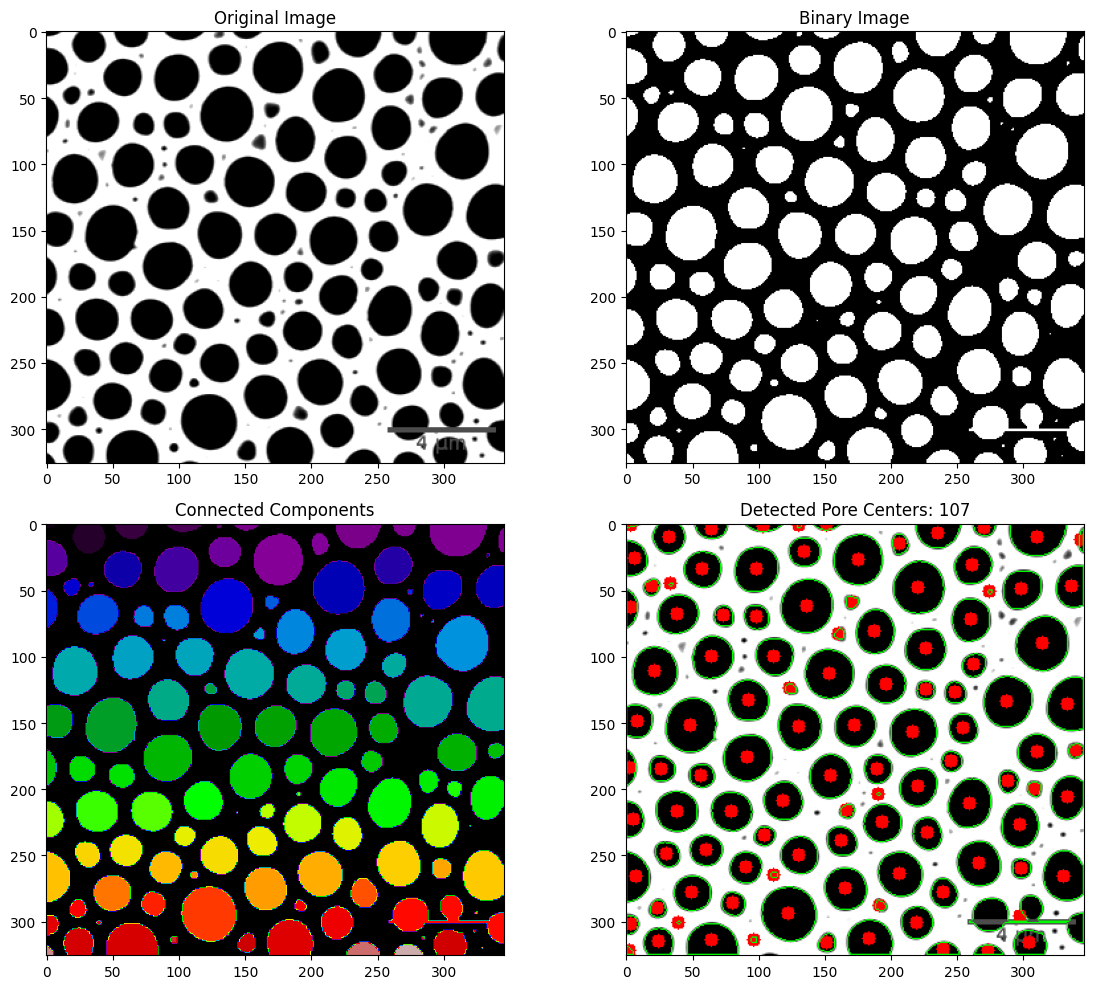

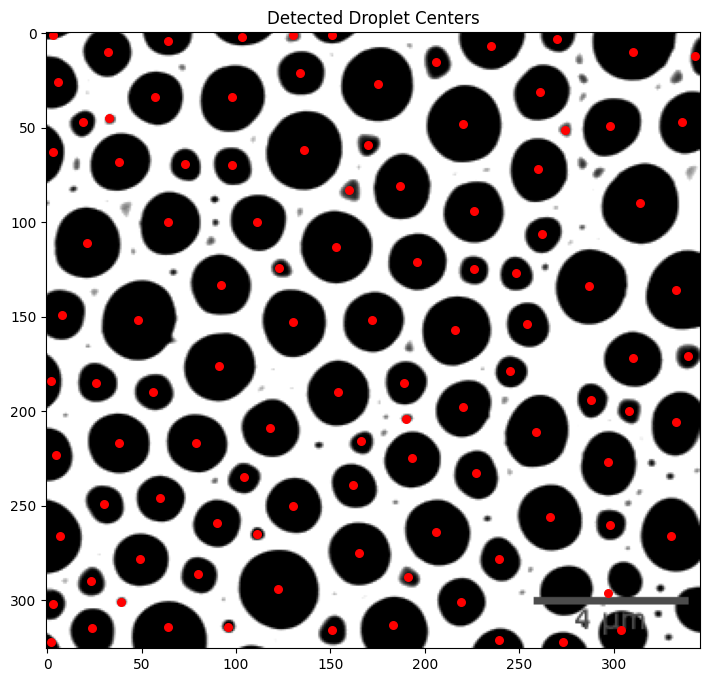

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample6B.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply binary threshold - simpler approach that works better for this image
# The black pores are already dark, so use a direct threshold
_, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)

# Find connected components (black regions)
nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Filter components by size
min_size = 5 # Minimum area to consider
max_size = 100000  # Maximum area to consider (to filter out background)

# Create output image for visualization
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Filter components and draw their centers
filtered_centroids = []
for i in range(1, nb_components):  # Skip first component (background)
    area = stats[i, cv2.CC_STAT_AREA]
    if min_size < area < max_size:
        # Get center coordinates
        cx = int(centroids[i, 0])
        cy = int(centroids[i, 1])
        
        # Calculate average intensity in the original image for this component
        component_mask = (labels == i).astype(np.uint8)
        mean_intensity = cv2.mean(image, mask=component_mask)[0]
        
        # Only keep dark components (pores are dark)
        if mean_intensity < 100:  # Adjust this threshold as needed
            filtered_centroids.append([cx, cy])
            
            # Draw a red dot at the center
            cv2.circle(output_image, (cx, cy), 5, (0, 0, 255), -1)
            
            # Optional: Draw the component boundary for visualization
            contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)

# Convert to NumPy array
print(filtered_centroids)
filtered_centroids = np.array(filtered_centroids)
print(f"Number of pores detected: {len(filtered_centroids)}")

# Display the result
plt.figure(figsize=(12, 10))
# Final result with centers
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Pore Centers: {len(filtered_centroids)}')

plt.tight_layout()
plt.savefig('improved_pore_detection.png', dpi=300)
plt.show()

# Save the results
np.save('pore_centroids.npy', filtered_centroids)
cv2.imwrite('pore_centers.png', output_image)

# Also create a simple visualization showing just the original image with centers
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.scatter(filtered_centroids[:, 0], filtered_centroids[:, 1], c='red', s=30)
plt.title('Detected Droplet Centers')
plt.savefig('droplet_centers.png', dpi=300)
plt.show()

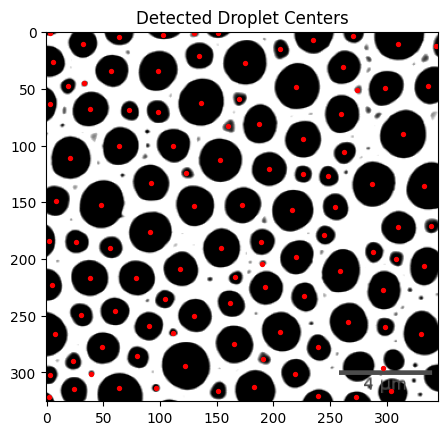

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample6B.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(image, 5)

# Use Otsu's thresholding to create a binary mask
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges using Canny edge detector
edges = cv2.Canny(closed, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert to color image for visualization
output_final = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)


centroids =np.array([[3, 1], [32, 10], [64, 4], [103, 2], [130, 1], [151, 1], [235, 7], [270, 3], [310, 10], [343, 12], [175, 27], [206, 15], [134, 21], [6, 26], [98, 34], [261, 31], [57, 34], [220, 48], [336, 47], [298, 49], [19, 47], [136, 62], [33, 45], [3, 63], [274, 51], [38, 68], [170, 59], [260, 72], [73, 69], [98, 70], [187, 81], [314, 90], [160, 83], [226, 94], [64, 100], [111, 100], [21, 111], [153, 113], [262, 106], [196, 121], [287, 134], [333, 136], [92, 133], [226, 125], [248, 127], [123, 124], [48, 152], [8, 149], [130, 153], [172, 152], [216, 157], [254, 154], [310, 172], [91, 176], [339, 171], [2, 184], [245, 179], [154, 190], [189, 185], [26, 185], [56, 190], [220, 198], [288, 194], [333, 206], [259, 211], [118, 209], [308, 200], [38, 217], [79, 217], [190, 204], [5, 223], [166, 216], [193, 225], [297, 227], [227, 233], [104, 235], [162, 239], [60, 246], [130, 250], [30, 249], [266, 256], [330, 266], [7, 266], [90, 259], [206, 264], [298, 260], [165, 275], [111, 265], [49, 278], [239, 278], [122, 294], [80, 286], [297, 296], [23, 290], [191, 288], [219, 301], [3, 302], [183, 313], [39, 301], [64, 314], [24, 315], [304, 316], [151, 316], [96, 314], [239, 321], [2, 322], [273, 322]]







)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()

## Perform Voronoi Tessellation

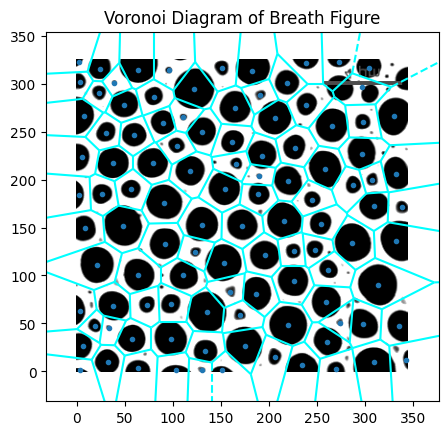

In [17]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(centroids)
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


# Beautifying because Science is Beautiful

Data bounds: X: 0 to 411, Y: 0 to 358
Total polygons to be plotted: 235


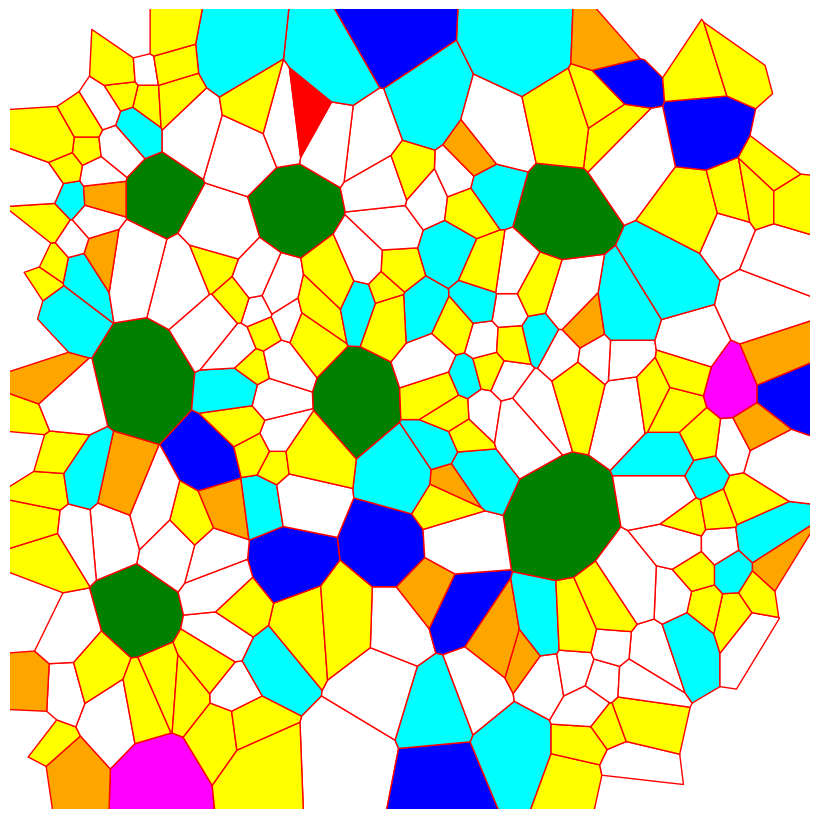

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Your points
points =  np.array([[72, 6], [170, 14], [224, 2], [262, 20], [318, 0], [383, 19], [4, 6], [298, 5], [16, 8], [124, 12], [319, 10], [9, 17], [301, 20], [1, 24], [104, 28], [117, 30], [312, 29], [44, 37], [324, 34], [302, 38], [221, 39], [63, 41], [110, 46], [19, 48], [2, 49], [73, 46], [85, 45], [242, 48], [310, 51], [326, 50], [130, 59], [35, 53], [189, 50], [278, 54], [294, 57], [98, 57], [59, 83], [334, 65], [267, 63], [403, 64], [314, 67], [255, 67], [18, 70], [106, 72], [276, 71], [295, 72], [355, 73], [390, 73], [147, 75], [198, 76], [0, 80], [171, 77], [380, 82], [315, 82], [113, 84], [230, 86], [364, 86], [348, 90], [137, 106], [286, 126], [393, 92], [327, 91], [217, 93], [411, 95], [104, 95], [198, 114], [379, 102], [360, 102], [401, 102], [99, 110], [11, 113], [353, 115], [372, 115], [79, 116], [228, 116], [392, 118], [8, 124], [44, 124], [87, 125], [24, 122], [66, 131], [356, 127], [371, 130], [106, 134], [126, 137], [223, 135], [349, 138], [11, 141], [49, 139], [385, 136], [29, 144], [143, 140], [364, 147], [206, 147], [227, 145], [236, 152], [101, 153], [133, 153], [146, 155], [396, 156], [12, 157], [349, 157], [123, 159], [223, 160], [177, 186], [381, 161], [0, 161], [361, 164], [63, 193], [133, 165], [235, 166], [391, 167], [117, 172], [1, 174], [245, 178], [262, 175], [349, 179], [229, 177], [14, 180], [379, 189], [129, 184], [270, 183], [323, 185], [335, 187], [6, 190], [115, 188], [406, 189], [223, 188], [297, 192], [235, 194], [258, 193], [353, 197], [122, 199], [248, 198], [321, 202], [134, 202], [219, 202], [402, 200], [288, 206], [305, 203], [0, 211], [114, 209], [245, 211], [275, 214], [356, 208], [260, 210], [230, 216], [127, 215], [298, 217], [321, 221], [394, 228], [150, 216], [211, 226], [102, 220], [139, 221], [259, 226], [156, 226], [194, 225], [289, 227], [348, 240], [15, 227], [243, 229], [123, 226], [179, 231], [112, 230], [133, 232], [0, 232], [272, 233], [166, 238], [8, 238], [121, 238], [191, 236], [259, 241], [27, 245], [86, 241], [198, 245], [225, 254], [247, 243], [182, 246], [55, 250], [99, 247], [143, 273], [14, 248], [284, 272], [38, 253], [402, 252], [3, 254], [24, 258], [102, 259], [197, 264], [376, 264], [68, 280], [34, 268], [12, 267], [362, 271], [215, 279], [379, 276], [23, 279], [236, 276], [394, 279], [409, 279], [37, 280], [11, 285], [246, 284], [195, 285], [232, 288], [36, 290], [205, 289], [403, 290], [21, 293], [366, 313], [240, 297], [411, 302], [31, 302], [46, 304], [213, 319], [324, 303], [17, 304], [251, 307], [115, 305], [184, 307], [162, 310], [56, 314], [88, 314], [316, 312], [31, 313], [137, 315], [288, 316], [151, 317], [41, 320], [15, 340], [121, 320], [309, 324], [63, 325], [78, 326], [166, 338], [52, 328], [108, 345], [319, 335], [51, 338], [63, 339], [364, 339], [74, 341], [269, 351], [378, 344], [316, 349], [60, 353], [71, 353], [411, 354], [192, 355], [386, 357], [325, 358], [339, 358]]









)

# Calculate the actual bounds of your data
x_min, y_min = points.min(axis=0)
x_max, y_max = points.max(axis=0)

print(f"Data bounds: X: {x_min} to {x_max}, Y: {y_min} to {y_max}")

# Add buffer to bounds for better visualization
buffer = 10
x_range = [x_min - buffer, x_max + buffer]
y_range = [y_min - buffer, y_max + buffer]

# Compute Voronoi Tessellation
vor = Voronoi(points)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Define colors based on number of sides
color_map = {
    3: 'red',
    4: 'orange',
    5: 'yellow',
    6: 'white',  # Most common in Voronoi are hexagons
    7: 'cyan',
    8: 'blue',
    9: 'magenta',
    10: 'green'  # For polygons with 10 or more sides
}

# Prepare patches and colors for filled regions
patches = []
patch_colors = []

# Process each Voronoi region
for i, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    
    # Skip if region is unbounded (contains -1)
    if -1 in region or len(region) == 0:
        continue
        
    # Get vertices for this region
    polygon = [vor.vertices[v] for v in region]
    
    # Skip regions that are completely outside the bounds
    # Modified to use actual data range instead of hardcoded 0-400
    if all(vertex[0] < x_range[0] or vertex[0] > x_range[1] or 
           vertex[1] < y_range[0] or vertex[1] > y_range[1] 
           for vertex in polygon):
        continue
    
    # Count number of sides (vertices)
    num_sides = len(polygon)
    
    # Create a polygon patch
    patches.append(Polygon(polygon))
    
    # Assign color based on number of sides
    if num_sides >= 10:
        patch_colors.append(color_map[10])  # Group all large polygons
    elif num_sides in color_map:
        patch_colors.append(color_map[num_sides])
    else:
        patch_colors.append('gray')  # Fallback color

# Print how many polygons we're actually plotting
print(f"Total polygons to be plotted: {len(patches)}")
        
# Create a patch collection with specified colors
patch_collection = PatchCollection(patches, alpha=1)
patch_collection.set_facecolor(patch_colors)
patch_collection.set_edgecolor('red')  # Red borders
patch_collection.set_linewidth(1.0)

# Add the patch collection to the plot
ax.add_collection(patch_collection)

ax.set_xlim(x_range)
ax.set_ylim(y_range)

# Remove axes for a clean look
ax.set_axis_off()
# Use a clean background with no padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout(pad=0)

plt.show()

## Analyze Voronoi Cell Shapes

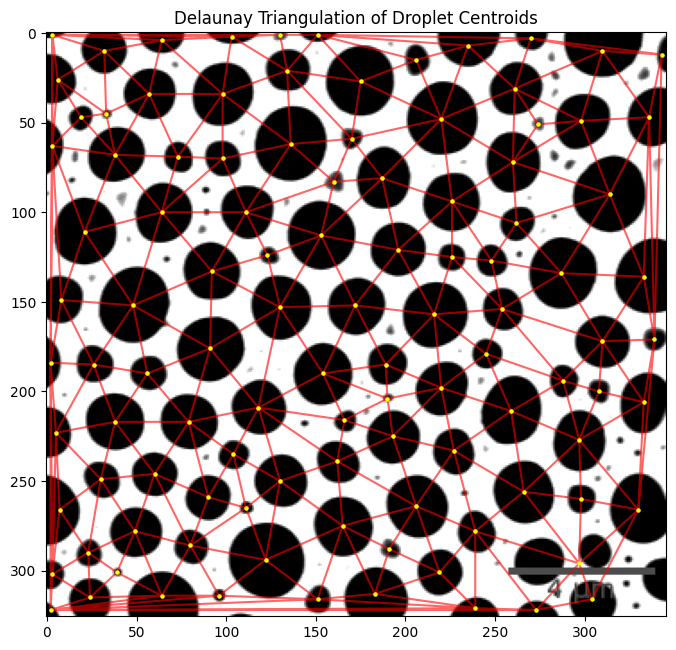

In [19]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
tri = Delaunay(centroids)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


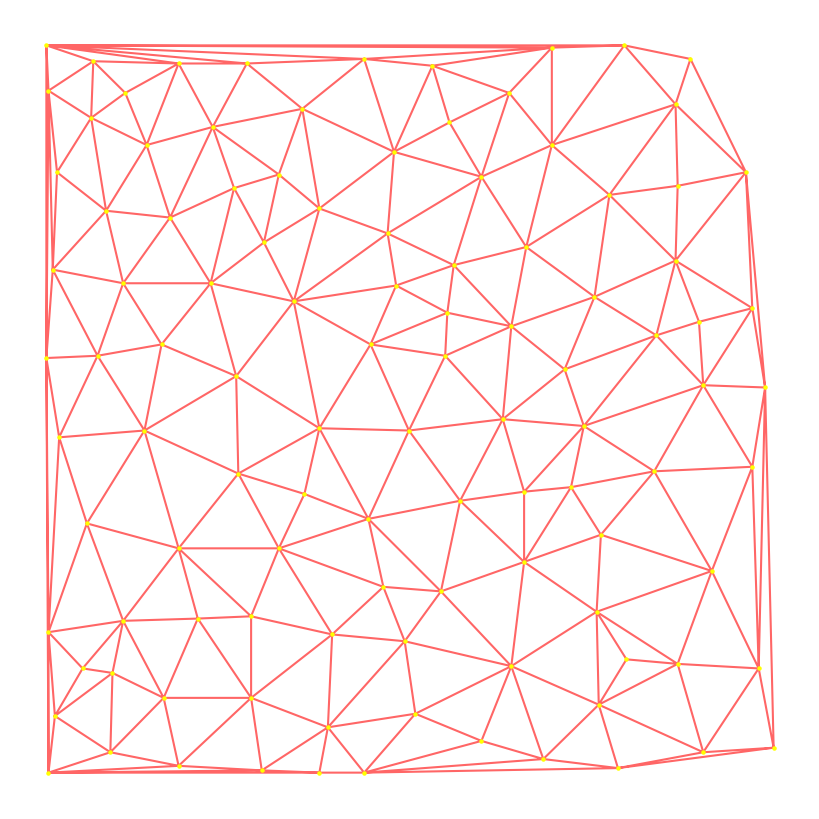

In [21]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

centroids =  np.array([[3, 1], [32, 10], [64, 4], [103, 2], [130, 1], [151, 1], [235, 7], [270, 3], [310, 10], [343, 12], [175, 27], [206, 15], [134, 21], [6, 26], [98, 34], [261, 31], [57, 34], [220, 48], [336, 47], [298, 49], [19, 47], [136, 62], [33, 45], [3, 63], [274, 51], [38, 68], [170, 59], [260, 72], [73, 69], [98, 70], [187, 81], [314, 90], [160, 83], [226, 94], [64, 100], [111, 100], [21, 111], [153, 113], [262, 106], [196, 121], [287, 134], [333, 136], [92, 133], [226, 125], [248, 127], [123, 124], [48, 152], [8, 149], [130, 153], [172, 152], [216, 157], [254, 154], [310, 172], [91, 176], [339, 171], [2, 184], [245, 179], [154, 190], [189, 185], [26, 185], [56, 190], [220, 198], [288, 194], [333, 206], [259, 211], [118, 209], [308, 200], [38, 217], [79, 217], [190, 204], [5, 223], [166, 216], [193, 225], [297, 227], [227, 233], [104, 235], [162, 239], [60, 246], [130, 250], [30, 249], [266, 256], [330, 266], [7, 266], [90, 259], [206, 264], [298, 260], [165, 275], [111, 265], [49, 278], [239, 278], [122, 294], [80, 286], [297, 296], [23, 290], [191, 288], [219, 301], [3, 302], [183, 313], [39, 301], [64, 314], [24, 315], [304, 316], [151, 316], [96, 314], [239, 321], [2, 322], [273, 322]]





)


tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
ax.set_axis_off()

plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout(pad=0)

plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.34


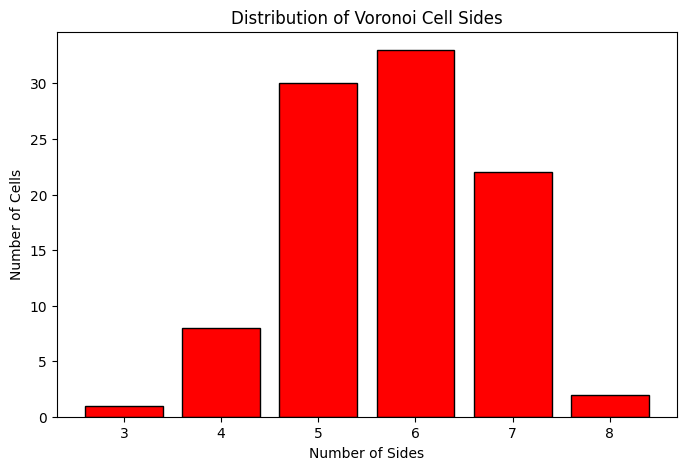

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
vor = Voronoi(centroids)

graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.show()

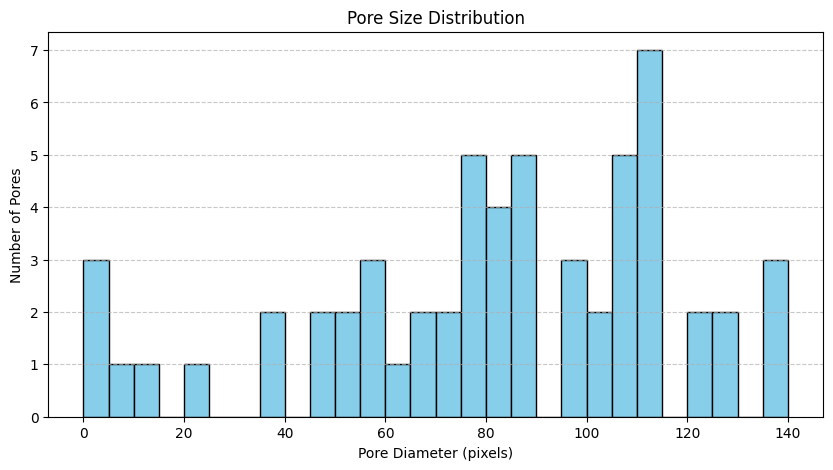

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()